In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import display, HTML

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
#Just to have each print in the same row
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [4]:
r'''
trusted_data_w_ocupacion: *trusted_data* with actual ocupacion included.
    path: r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
    
data_w_operacion: (DataFrame) data with the corresponding operacion (Entrada/Salida).
    path: C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv

'''

trusted_data_path_w_ocupacion = r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
data_w_operacion_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv'

In [5]:
def add_ocupacion(d, street, inplace=False):
    '''
    Includes a new column called ocupacion and adds one to a row
        if its an "Entrada" and substract one if its "Salida".
    
    Parameters:
        d: (DataFrame) dataframe model to include the new column
        inplace: (Boolean) if use a reference of d or make a copy instead.
        
    Return:
        out: the d reference or copy that contains the new column ocupacion
            with the correct values.
    
    '''
    def sum_ocup(row):
        '''
        Just for the apply func. If the row value is Entrada we sum 1,
        otherwise we subs 1.
        On each day we restart the actual_ocup.
        '''
        nonlocal actual_ocup, last_day

        if pd.to_datetime(row['fecha']).day != last_day:
            actual_ocup = 0
            last_day = pd.to_datetime(row['fecha']).day

        if row['operacion'] == 'Entrada':
            actual_ocup += 1
        else:
            if row['operacion'] == 'Salida':
                if actual_ocup > 0:
                    actual_ocup -= 1
        return actual_ocup

    #To use a reference or a copy of the input
    if inplace:
        out = d
    else:
        out = d.copy()

    out['fecha'] = out['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())

    actual_ocup = 0
    last_day = pd.to_datetime(out['fecha'].min()).day
    out.loc[out['id_cuadra'] == street, 'ocupacion'] = out.loc[out['id_cuadra'] == street, ['operacion', 'fecha']].apply(sum_ocup, axis=1)

    out.drop('fecha', axis=1, inplace=True)

    if not inplace:
        return out

In [6]:
def reorder_españa(data, inplace=False):
    #Keep only one España street.
    # ESTO ESTA MAL TENGO QUE SUMAR EL OCUPADO SINO NO SIRVE
    if inplace:
        out = data
    else:
        out = data.copy()
        
    original = 85
    to_del = 93
    for i in range(91-85+1):
        out.loc[out.id_cuadra == to_del+i, 'id_cuadra'] = out.loc[out.id_cuadra == original+i, 'id_cuadra'].iloc[0]
        out.loc[out.id_cuadra == to_del+i, 'direccion'] = out.loc[out.id_cuadra == original+i, 'direccion'].iloc[0]

    out.sort_values(by=['id_cuadra','fecha_hora'], inplace=True, ascending=True)
    
    for i in range(91-85+1):
        add_ocupacion(out, street=original+i, inplace=True)

In [7]:
SUMO_data = pd.read_csv(data_w_operacion_path)
SUMO_data.rename(columns={'fecha_tiempo': 'fecha_hora'}, inplace=True)
#SUMO_data['fecha_hora'] = SUMO_data['fecha_hora'].apply(lambda x: pd.Timestamp(x))

#We dont want the SUMO office to appear in any data, cause there is no place to park
SUMO_data = SUMO_data.loc[SUMO_data.id_cuadra != 50]

#We only want one españa per street, but we need to correct the ocupacion
reorder_españa(SUMO_data, inplace=True)

BD_parking_data = pd.read_csv(trusted_data_path_w_ocupacion)

In [8]:
#Weekday data FOR SUMO
weekday_data = SUMO_data.copy()
weekday_data['dia de semana'] = weekday_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).weekday())
#0:Monday 1:Tuesday 2:Wednesday 3:Thursday 4:Friday 5:Saturday 6:Sunday
weekday = 0
weekday_data = weekday_data.loc[weekday_data['dia de semana'] == 0]

In [9]:
def modif_date(data, n):
    '''n is the number of the date (e.g. 2 is the second date in the data df)'''
    if date_n < len(data):
        date = data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date()).drop_duplicates().iloc[date_n]
    else:
        date = data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date()).drop_duplicates().iloc[len(data)-1]
    return pd.Timestamp(date).date()

# Choose the data

In [10]:
#DF to process...
#You can put on data any filter you want. If you put only monday data all the graphs
#below will be for monday values...
data = SUMO_data.copy()
#data = weekday_data.copy()
#data = BD_parking_data.copy()

#Street to process...
#From 2 to 92 without 50
street = 59

#Date to process...
#Select a number from 0 to data['fecha_hora'] len.
date_n = 1

date = modif_date(data, date_n)

#Hour to process...
hour = 10


print('Street :  {} ({})'.format(street, data.loc[data['id_cuadra'] == street, 'direccion'].iloc[0]))
print('Date   : ', date)
print('Hour   : ', hour)

Street :  59 (Yrigoyen 655)
Date   :  2019-09-12
Hour   :  10


## Cuadras donde más se estaciona (SUMO)

In [11]:
def get_max_ocupacion(data):
    '''
    Obtain the max ocupacion per street.
    
    Parameters:
        data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        max_ocupacion: all max ocupation for all streets
        max_max_ocupacion: max_ocupacion.tail(10)
        less_max_ocupacion: max_ocupacion.head(10)
    '''
    
    max_ocupacion = data.copy()
    max_ocupacion = max_ocupacion[['id_cuadra','ocupacion_max', 'lugares_cuadra']].groupby(by='id_cuadra').max().reset_index()
    max_ocupacion = max_ocupacion.sort_values(by='ocupacion_max')

    max_ocupacion = max_ocupacion.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))

    #Add the mean of the ocupation of each day
    data['fecha'] = data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())
    aux = data[['id_cuadra','fecha','ocupacion']].groupby(by=['id_cuadra','fecha']).max().reset_index().groupby(by='id_cuadra').mean().reset_index()
    aux.rename(columns={'ocupacion': 'real_max_ocupacion_mean'}, inplace=True)
    max_ocupacion = max_ocupacion.merge(aux)
    
    less_max_ocupacion = max_ocupacion[['id_cuadra','direccion','ocupacion_max', 'real_max_ocupacion_mean', 'lugares_cuadra']].head(10).reset_index(drop=True)
    max_max_ocupacion = max_ocupacion[['id_cuadra','direccion','ocupacion_max', 'real_max_ocupacion_mean', 'lugares_cuadra']].tail(10).reset_index(drop=True)
    
    data.drop('fecha', axis=1)
    
    max_max_ocupacion = max_max_ocupacion.sort_values(by='ocupacion_max',ascending=False).reset_index(drop=True)
    return max_ocupacion, max_max_ocupacion, less_max_ocupacion

In [12]:
max_ocupacion, max_max_ocupacion, less_max_ocupacion = get_max_ocupacion(data)

In [13]:
display(max_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,real_max_ocupacion_mean,lugares_cuadra
0,59,Yrigoyen 655,42,21.860000,48.0
1,60,Fuerte Independencia 349,29,14.367347,44.0
2,14,Rodriguez 464,27,10.693878,30.0
3,32,Sarmiento 453,27,15.755102,27.0
4,72,Maipu 453,27,11.125000,33.0
5,75,Maipu 333,27,15.652174,31.0
6,33,Sarmiento 755,26,16.720000,32.0
7,82,General Paz 647,26,12.489796,34.0
8,21,Belgrano 540,24,13.788462,29.0
9,6,General Pinto 759,24,14.489796,30.0


In [14]:
display(less_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,real_max_ocupacion_mean,lugares_cuadra
0,92,Tribunal de Faltas,1,0.600000,NaN
1,78,Maipu 953,6,3.095238,14.0
2,88,Av. España 647,7,6.640000,11.0
3,85,Av. España 359,7,3.617021,7.0
4,77,Maipu 857,7,3.750000,15.0
5,86,Av. España 481,8,4.565217,10.0
6,25,Belgrano 958,8,4.000000,13.0
7,69,14 de Julio 657,9,4.510638,10.0
8,28,General Pinto 945,10,5.270833,12.0
9,55,14 de Julio 467,11,5.520000,13.0


### Para esto todavia faltaria tener mas datos y poder deducir algo del maximo valor posible. Por ahora ningun dato tiene sentido y por la poca cantidad tampoco puedo deducir mucho.

## Cuadras de mas y menos transito (input-ouputs) (SUMO)

In [15]:
def traffic_density(data):
    '''
    Obtain the traffic density (how much in-outs) per street.
    
    Parameters:
        SUMO_data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        traffic: all traffic density for all streets
        max_traffic: traffic.tail(10)
        min_traffic: traffic.head(10)
    '''
    traffic = data.copy()
    traffic = traffic[['id_cuadra','direccion']].groupby(by='id_cuadra').count().reset_index()
    traffic.rename(columns={'direccion': 'in-outs'}, inplace=True)
    traffic = traffic.sort_values(by='in-outs')
    traffic = traffic.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))
    max_traffic = traffic[['id_cuadra','direccion','in-outs']].tail(10).sort_values(by='in-outs', ascending=False).reset_index(drop=True)
    min_traffic = traffic[['id_cuadra','direccion','in-outs']].head(10).reset_index(drop=True)
    return traffic, max_traffic, min_traffic

In [16]:
_, max_traffic, min_traffic = traffic_density(data)

In [17]:
display(min_traffic)
display(max_traffic)

,id_cuadra,direccion,in-outs
0,92,Tribunal de Faltas,13
1,79,General Paz 347,711
2,77,Maipu 857,774
3,78,Maipu 953,808
4,71,14 de Julio 847,882
5,25,Belgrano 958,959
6,85,Av. España 359,1034
7,70,14 de Julio 767,1043
8,41,Mitre 446,1269
9,69,14 de Julio 657,1282


,id_cuadra,direccion,in-outs
0,59,Yrigoyen 655,5607
1,11,San Martín 658,5174
2,6,General Pinto 759,5080
3,33,Sarmiento 755,4865
4,4,Rodriguez 552,4854
5,45,Alem 480,4793
6,89,Av. España 737,4750
7,75,Maipu 333,4373
8,46,Alem 556,4371
9,34,Sarmiento 849,4283


## To plot day activity graphs

In [18]:
def get_filtered_time(plot_data, k=5):
    '''
    Obtains a dataframe with fixed dates to plot
    
    Parameters: 
        plot_data_date: dataframe containing the fecha_hora values of the plotted data
        k: how much dates will appear in the graph
        
    Returns: a dataframe containing only k dates and empty values
    '''
    
    #Get the timestamp of the fecha_hora column
    time = plot_data['fecha_hora'].reset_index(drop=True).apply(lambda x: pd.Timestamp(x)).copy()
    
    #Obtain the nearest row to 13:00hs
    '''same_hour = time.apply(lambda x: x.hour == 13)
    same_minutes = time.apply(lambda x: x.minute < 10)
    same_time = same_hour * same_minutes
    same_time_index = time[same_time].index[0]
    '''
    #Get the k values to be appended in the out (time var)
    size = len(time)
    pos = [0]
    vals = [str(time[pos[0]].time())]
    for i in range(1,k+1):
        pos.append(int(size*(i/k)) - 1)
        vals.append(str(time[pos[i]].time()))
    #pos[int(len(pos)/2)+1] = same_time_index
    #vals[int(len(vals)/2)+1] = str(time[pos[int(len(vals)/2)+1]].time())
    '''pos = [0, int(size*(1/4)), same_time_index, int(size*(3/4)), int(size-1)]
    val1 = str(time[pos[0]].time())
    val2 = str(time[pos[1]].time())
    val3 = str(time[pos[2]].time())
    val4 = str(time[pos[3]].time())
    val5 = str(time[pos[4]].time())
    '''
    #Fill with empty values the time Series
    time = pd.Series('', index=time.index)
    
    #Put all obtained values into time Series
    for i in range(k+1):
        time.iloc[pos[i]] = vals[i]
    '''time.iloc[pos[0]] = val1
    time.iloc[pos[1]] = val2
    time.iloc[pos[2]] = val3
    time.iloc[pos[3]] = val4
    time.iloc[pos[4]] = val5
    '''
    return time

In [19]:
def plot_line_graph(plot_data, date, street, max_ocup=30, name='Original', color='b', k=5):

    #Get the values for each date we have
    plot_data_date = plot_data.loc[plot_data.fecha == pd.Timestamp(date).date()].copy()

    #Obtaining the mean to plot in the title of the graph
    mean = plot_data_date['ocupacion'].mean()
    #Modify the plot size
    plt.rcParams['figure.figsize'] = (12,4)
    
    #The max value
    plt.ylim([0, max_ocup+1])

    #Just for the x axis, get the first, medium and last time value
    if k > len(plot_data_date):
        time = get_filtered_time(plot_data_date, len(plot_data_date))
    else:
        time = get_filtered_time(plot_data_date, k)
                
    #Set the label titles
    plt.xlabel('Time')
    plt.ylabel('Parked cars')
    plt.title('Parked cars in street nº{} along the day ({}). Mean parked cars: {}. Sample of {} parked cars'.format(street, date, mean, len(plot_data_date)))
    
    #Set the plot data for each graph (ax1,ax2,ax3)
    plt.plot(plot_data_date['fecha_hora'], plot_data_date['ocupacion'], label='{} date'.format(name), color=color)
    
    plt.xticks(plot_data_date['fecha_hora'], time)
    plt.legend()
    plt.show()

In [20]:
def get_max_min_mean_dates(to_plot_data, street, date):
    street_name = to_plot_data.loc[to_plot_data.id_cuadra == street, 'direccion'].iloc[0]

    plot_data = to_plot_data.loc[to_plot_data.id_cuadra == street, ['fecha_hora','ocupacion']].copy()

    plot_data['fecha'] = plot_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())

    '''max_mean = plot_data.groupby(by='fecha').mean().max()[0]
    date_max_mean = plot_data.groupby(by='fecha').mean().reset_index()
    date_max_mean = date_max_mean.loc[date_max_mean['ocupacion'] == max_mean, 'fecha'].iloc[0]
    '''
    def search_date_of_mean(p_d, what, min_quantity=150):
        '''
        To search the day with *what* parked cars, but with at least
        min_quantity registers (rows)
        '''
        plot_data = p_d.copy()
        full_mean = plot_data.groupby(by='fecha').mean().reset_index()

        if what=='max':
            mean = full_mean['ocupacion'].max()
        elif what=='min':
            mean = full_mean['ocupacion'].min()

        date_of_mean = full_mean.loc[full_mean['ocupacion'] == mean, 'fecha'].iloc[0]
        
        #If the date min mean have values from 9hs to 20hs or more we want it, else no...
        plot_data_of_date = plot_data.loc[plot_data['fecha'] == date_of_mean, 'fecha_hora'].reset_index(drop=True)
        
        if (pd.Timestamp(plot_data_of_date.iloc[0]).time().hour < 9) and (pd.Timestamp(plot_data_of_date.iloc[len(plot_data_of_date)-1]).time().hour > 19):
            if min_quantity == 0:
                return date_of_mean
            elif len(plot_data_of_date) > min_quantity:
                return date_of_mean
            else:
                return search_date_of_mean(plot_data.loc[plot_data['fecha'] != date_of_mean], what, min_quantity)
        else:
            return search_date_of_mean(plot_data.loc[plot_data['fecha'] != date_of_mean], what, min_quantity)

    #Date when there was the max mean parked cars in select street
    date_max_mean = search_date_of_mean(plot_data, what='max', min_quantity=0)
    
    #Date when there was the min mean parked cars in select street
    date_min_mean = search_date_of_mean(plot_data, what='min', min_quantity=0)

    print(street_name)

    #Getting the max ocup to plot all the graphs with the same y-axis values
    max_ocup1 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date).date(),'ocupacion'].max()
    max_ocup2 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_max_mean).date(), 'ocupacion'].max()
    max_ocup3 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_min_mean).date(), 'ocupacion'].max()

    max_ocup = max(max_ocup1, max_ocup2, max_ocup3)
    
    return plot_data, date_max_mean, date_min_mean, max_ocup 

In [21]:
plot_data, date_max_mean, date_min_mean, max_ocup = get_max_min_mean_dates(data, street, date)

Yrigoyen 655


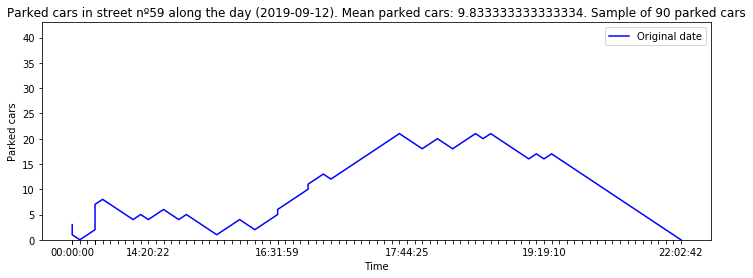

In [22]:
plot_line_graph(plot_data, date, street=street, max_ocup=max_ocup)

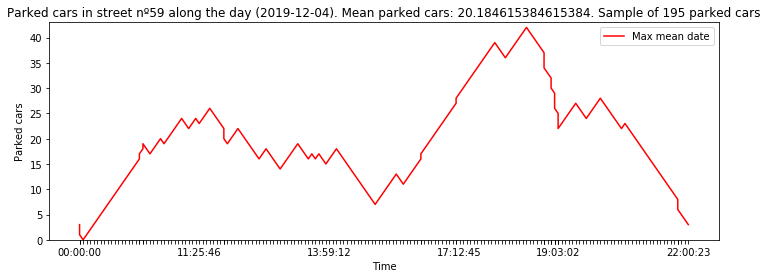

In [23]:
plot_line_graph(plot_data, date_max_mean, street=street, max_ocup=max_ocup, name='Max mean', color='r')

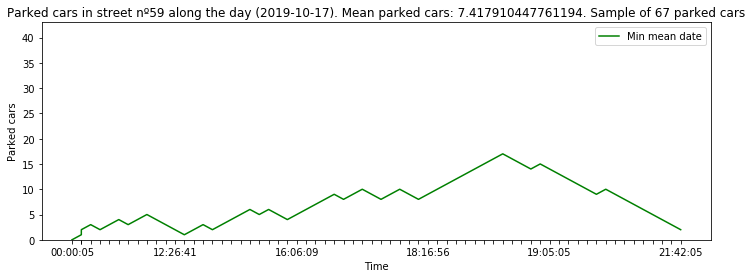

In [24]:
plot_line_graph(plot_data, date_min_mean, street=street, max_ocup=max_ocup, name='Min mean', color='g')

## En una ventana de tiempo la cantidad de entradas y salidas que se tienen para poder predecir donde se podrian liberar lugares para estacionar mas frecuentemente

In [25]:
def inputs_outputs_per_hour(data):
    '''
    Obtain the inputs and outputs (and the sub of both) per street.
    
    Parameters:
        SUMO_data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        in_out_per_hour: (DataFrame) df that contains the inputs, the outputs 
        and the sub: entradas-salidas.
    '''
    
    #Create column dia and tiempo just to obtain the inputs and outputs in an easy way
    in_out_per_hour= data.copy()
    in_out_per_hour = in_out_per_hour[['id_cuadra','fecha_hora','operacion']]
    in_out_per_hour['dia'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).date().day)
    in_out_per_hour['tiempo'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).time().hour)

    #Obtain 2 df, one with the count of the inputs and the other with the count of the outputs
    in_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Entrada', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
    out_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Salida', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
    in_per_hour.rename(columns={'operacion': 'entradas'}, inplace=True)
    out_per_hour.rename(columns={'operacion': 'salidas'}, inplace=True)

    #Obtain the mean of the inputs and outputs
    in_per_hour = in_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()
    out_per_hour = out_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()

    #Merge both in and out per hour to get the diff
    in_out_per_hour = in_per_hour.merge(out_per_hour, how='outer', on=['id_cuadra','tiempo'])
    in_out_per_hour.fillna(0, inplace=True)

    #Subs values
    in_out_per_hour['in - out'] = in_out_per_hour['entradas'] - in_out_per_hour['salidas']
    in_out_per_hour.rename(columns={'tiempo': 'hora'}, inplace=True)

    return in_out_per_hour

In [26]:
in_out_per_hour = inputs_outputs_per_hour(data)

### All streets info (in-outs)

In [27]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
display(in_out_per_hour.loc[in_out_per_hour.id_cuadra == 59])

,id_cuadra,hora,entradas,salidas,in - out
791,59,6,1.000000,0.000000,1.000000
792,59,7,1.533333,2.750000,-1.216667
793,59,8,2.055556,2.500000,-0.444444
794,59,9,9.464286,1.916667,7.547619
795,59,10,18.000000,4.107143,13.892857
796,59,11,8.344828,9.620690,-1.275862
797,59,12,5.814815,12.250000,-6.435185
798,59,13,8.428571,8.214286,0.214286
799,59,14,5.884615,8.703704,-2.819088
800,59,15,5.653846,6.250000,-0.596154


### Selected street info (in-outs) ordered by hora and by in-out

In [28]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
print(data.loc[data.id_cuadra == street, 'direccion'].iloc[0])

Yrigoyen 655


In [29]:
#First we display the in-out for the designated street orderer by the hora
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].reset_index(drop=True))

#And at the right we will display the in-out orderer by the in-out (ascendant)
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].sort_values(by='in - out').reset_index(drop=True))

,hora,in - out
0,6,1.000000
1,7,-1.216667
2,8,-0.444444
3,9,7.547619
4,10,13.892857
5,11,-1.275862
6,12,-6.435185
7,13,0.214286
8,14,-2.819088
9,15,-0.596154


,hora,in - out
0,20,-10.428571
1,12,-6.435185
2,19,-6.392857
3,21,-4.538462
4,0,-4.294118
5,14,-2.819088
6,22,-1.800000
7,23,-1.333333
8,11,-1.275862
9,7,-1.216667


# Heat map

In [30]:
def get_data_for_scatter_graph(data, hour, date=None):
    '''
    Parameters:
        data: (DataFrame) full data that contains all rows with all ocupacion changes.
        hour: (int) the hour of the day to see the mean parked cars.
    Return:
        scatter_data: (DataFrame) df that contains the data to be plotted in the scatter 
    '''
    
    scatter_data = data.copy()[['id_cuadra', 'direccion', 'fecha_hora','ocupacion', 'ocupacion_max']]

    #Obtain the coordenadas and direccion for each street
    scatter_data = scatter_data.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_coordenadas.csv'))
    scatter_data = scatter_data.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))

    #Obtain all streets (also that who dont have any ocupacion at designated hour)
    all_streets = scatter_data[['id_cuadra','direccion','latitud','longitud']].copy().drop_duplicates()

    if date != None:
        scatter_data['fecha'] = scatter_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())
        scatter_data = scatter_data.loc[scatter_data['fecha'] == date]
    
    scatter_data['hora'] = scatter_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).time().hour)
    scatter_data = scatter_data.loc[scatter_data['hora'] == hour]

    #Calculate the mean of all the ocupacion for designated hour
    scatter_data = scatter_data.groupby(by=['id_cuadra','direccion']).mean().reset_index()[['id_cuadra', 'direccion', 'latitud','longitud','ocupacion']]

    
    def complete_streets(data, streets, inplace=False):
        '''
        Used to complete the data with all the missing streets. In those streets
        the ocupacion will be equals to 0.
        '''
        if not inplace:
            out = data.copy()
        else:
            out = data
        for i, row in streets.iterrows():
            if not (out['id_cuadra'] == row['id_cuadra']).any():
                to_add = row.copy()
                to_add['ocupacion'] = 0
                out = out.append(to_add)
        if not inplace:
            return out
        return out
    
    #Complete the data with missing streets
    scatter_data = complete_streets(scatter_data, all_streets, inplace=True)

    #Put max ocupacion on them
    scatter_data = scatter_data.merge(max_ocupacion[['id_cuadra', 'ocupacion_max']], on='id_cuadra').sort_values(by='id_cuadra')

    #Invert latitud to transform the scatter in a nice to see map
    scatter_data['latitud'] = scatter_data['latitud'] * -1
    #scatter_data['longitud'] = scatter_data['longitud']
    
    return scatter_data

In [31]:
def get_color_for_scatter_graph(scatter_data):
    
    #Because im now using my own maximun (mean of all max on each day)
    global max_ocupacion
    max_ocup = max_ocupacion.copy()
    max_ocup = max_ocup.sort_values(by='id_cuadra').reset_index(drop=True)
    scatter_data = scatter_data.sort_values(by='id_cuadra').reset_index(drop=True)
    
    color_green_data = scatter_data['ocupacion'] <= (max_ocup['real_max_ocupacion_mean'] * 1/4)
    color_yellow_data = (~color_green_data) & (scatter_data['ocupacion'] <= (max_ocup['real_max_ocupacion_mean'] * 2/4))
    color_orange_data = (~color_green_data) & (~color_yellow_data) & (scatter_data['ocupacion'] <= (max_ocup['real_max_ocupacion_mean'] * 3/4))
    color_red_data = (~color_green_data) & (~color_yellow_data) & (~color_orange_data)

    color_data = pd.DataFrame(index=scatter_data.index.values, columns=['color'])
    color_data[color_green_data] = 'green'
    color_data[color_yellow_data] = 'yellow'
    color_data[color_orange_data] = 'orange'
    color_data[color_red_data] = 'red'

    #Tribunal de faltas, we dont need this data, neither SUMO office data (we ve already deleted it)
    color_data.iloc[88] = 'purple'

    color_list = []
    for c in color_data.values:
        color_list.append(c[0])

    color_data = color_list
    
    return color_data

In [32]:
scatter_data = get_data_for_scatter_graph(data, hour)
#color_data = get_color_for_scatter_graph(scatter_data)
color_data = get_color_for_scatter_graph(scatter_data)

In [33]:
def plot_scatter_map(scatter_data, color_data, hour, date=None):
    plt.scatter(scatter_data['latitud'], scatter_data['longitud'], c=color_data)
    if date==None:
        plt.title('Scatter for hour {}'.format(hour))
    else:
        plt.title('Scatter for date {} and hour {}'.format(date, hour))
    plt.axis('off')
    plt.show()

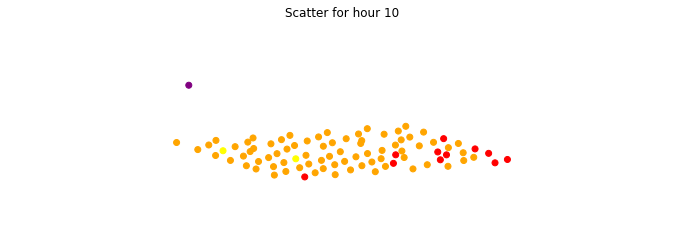

In [34]:
plot_scatter_map(scatter_data, color_data, hour)

# This is what i've done to correct date mistake in the original (v0) csv

In [35]:
'''SUMO_data = pd.read_csv(data_w_operacion_path)
SUMO_data'''
print()

In [36]:
'''SUMO_data['fecha'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).date())
SUMO_data['hora'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).time())
SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=11), x))
SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=12), x))
SUMO_data.drop(['fecha','hora'], axis=1, inplace=True)
SUMO_data['fecha_tiempo'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x))
SUMO_data'''
print()

In [37]:
#SUMO_data.to_csv(data_w_operacion_path,index=False)

.

.

.

.

.

.

# Just ouputs

In [38]:
#DF to process...
#You can put on data any filter you want. If you put only monday data all the graphs
#below will be for monday values...
data = SUMO_data.copy()
#data = weekday_data.copy()
#data = BD_parking_data.copy()

#Street to process...
#From 2 to 92 without 50
street = 2

#Date to process...
#Select a number from 0 to data['fecha_hora'] len. Try to avoid 0
date_n = 1

date = modif_date(data, date_n)

#Hour to process...
hour = 10


print('Street :  {} ({})'.format(street, data.loc[data['id_cuadra'] == street, 'direccion'].iloc[0]))
print('Date   : ', date)
print('Hour   : ', hour)

Street :  2 (General Pinto 545)
Date   :  2019-09-12
Hour   :  10


## Ocupation per street

### Top 10 ocupped streets

In [39]:
display(max_ocupacion[['id_cuadra','direccion','ocupacion_max','real_max_ocupacion_mean','lugares_cuadra']])

,id_cuadra,direccion,ocupacion_max,real_max_ocupacion_mean,lugares_cuadra
0,92,Tribunal de Faltas,1,0.600000,NaN
1,78,Maipu 953,6,3.095238,14.0
2,88,Av. España 647,7,6.640000,11.0
3,85,Av. España 359,7,3.617021,7.0
4,77,Maipu 857,7,3.750000,15.0
5,86,Av. España 481,8,4.565217,10.0
6,25,Belgrano 958,8,4.000000,13.0
7,69,14 de Julio 657,9,4.510638,10.0
8,28,General Pinto 945,10,5.270833,12.0
9,55,14 de Julio 467,11,5.520000,13.0


In [40]:
display(max_max_ocupacion[['id_cuadra','direccion','ocupacion_max','real_max_ocupacion_mean','lugares_cuadra']])

,id_cuadra,direccion,ocupacion_max,real_max_ocupacion_mean,lugares_cuadra
0,59,Yrigoyen 655,42,21.860000,48.0
1,60,Fuerte Independencia 349,29,14.367347,44.0
2,14,Rodriguez 464,27,10.693878,30.0
3,32,Sarmiento 453,27,15.755102,27.0
4,72,Maipu 453,27,11.125000,33.0
5,75,Maipu 333,27,15.652174,31.0
6,33,Sarmiento 755,26,16.720000,32.0
7,82,General Paz 647,26,12.489796,34.0
8,21,Belgrano 540,24,13.788462,29.0
9,6,General Pinto 759,24,14.489796,30.0


### Top 10 less ocupped streets

In [41]:
display(less_max_ocupacion[['id_cuadra','direccion','ocupacion_max','real_max_ocupacion_mean','lugares_cuadra']])

,id_cuadra,direccion,ocupacion_max,real_max_ocupacion_mean,lugares_cuadra
0,92,Tribunal de Faltas,1,0.600000,NaN
1,78,Maipu 953,6,3.095238,14.0
2,88,Av. España 647,7,6.640000,11.0
3,85,Av. España 359,7,3.617021,7.0
4,77,Maipu 857,7,3.750000,15.0
5,86,Av. España 481,8,4.565217,10.0
6,25,Belgrano 958,8,4.000000,13.0
7,69,14 de Julio 657,9,4.510638,10.0
8,28,General Pinto 945,10,5.270833,12.0
9,55,14 de Julio 467,11,5.520000,13.0


## Traffic per street (how much input-outputs)

In [42]:
display(min_traffic)
display(max_traffic)

,id_cuadra,direccion,in-outs
0,92,Tribunal de Faltas,13
1,79,General Paz 347,711
2,77,Maipu 857,774
3,78,Maipu 953,808
4,71,14 de Julio 847,882
5,25,Belgrano 958,959
6,85,Av. España 359,1034
7,70,14 de Julio 767,1043
8,41,Mitre 446,1269
9,69,14 de Julio 657,1282


,id_cuadra,direccion,in-outs
0,59,Yrigoyen 655,5607
1,11,San Martín 658,5174
2,6,General Pinto 759,5080
3,33,Sarmiento 755,4865
4,4,Rodriguez 552,4854
5,45,Alem 480,4793
6,89,Av. España 737,4750
7,75,Maipu 333,4373
8,46,Alem 556,4371
9,34,Sarmiento 849,4283


## Ocupation for a designated street along the day

### Graph for designated date

In [43]:
plot_data, date_max_mean, date_min_mean, max_ocup = get_max_min_mean_dates(data, street, date)

General Pinto 545


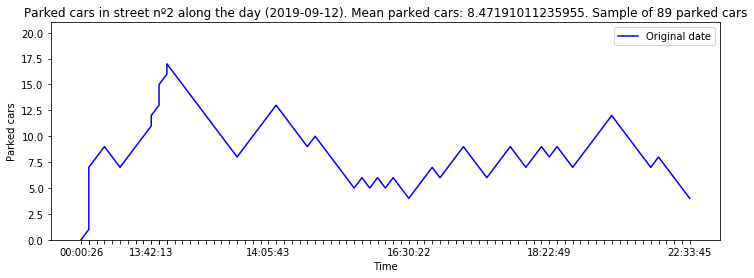

In [44]:
plot_line_graph(plot_data, date, street=street, max_ocup=max_ocup)

### Graph for the date with max mean of parked cars

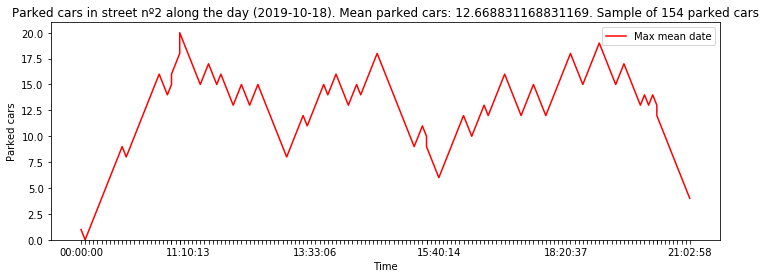

In [45]:
plot_line_graph(plot_data, date_max_mean, street=street, max_ocup=max_ocup, name='Max mean', color='r')

### Graph for the date with min mean of parked cars

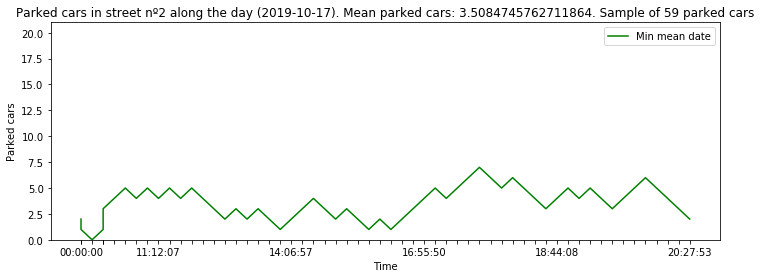

In [46]:
plot_line_graph(plot_data, date_min_mean, street=street, max_ocup=max_ocup, name='Min mean', color='g')

## In-outs per hour on each street

In [47]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
display(in_out_per_hour)

,id_cuadra,hora,entradas,salidas,in - out
0,2,7,1.142857,1.666667,-0.523810
1,2,8,2.277778,2.000000,0.277778
2,2,9,6.304348,1.722222,4.582126
3,2,10,11.259259,5.166667,6.092593
4,2,11,6.777778,8.884615,-2.106838
5,2,12,6.923077,7.730769,-0.807692
6,2,13,9.538462,8.518519,1.019943
7,2,14,7.250000,8.692308,-1.442308
8,2,15,3.550000,7.222222,-3.672222
9,2,16,6.583333,3.958333,2.625000


## In-outs per hour on designated street

In [48]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
print(data.loc[data.id_cuadra == street, 'direccion'].iloc[0])

General Pinto 545


In [49]:
#First we display the in-out for the designated street orderer by the hora
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].reset_index(drop=True))

#And at the right we will display the in-out orderer by the in-out (ascendant)
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].sort_values(by='in - out').reset_index(drop=True))

,hora,in - out
0,7,-0.523810
1,8,0.277778
2,9,4.582126
3,10,6.092593
4,11,-2.106838
5,12,-0.807692
6,13,1.019943
7,14,-1.442308
8,15,-3.672222
9,16,2.625000


,hora,in - out
0,20,-4.240000
1,15,-3.672222
2,0,-3.357143
3,19,-3.125000
4,11,-2.106838
5,21,-1.538462
6,14,-1.442308
7,22,-1.250000
8,23,-1.000000
9,12,-0.807692


## Heat map

In [50]:
scatter_data = get_data_for_scatter_graph(data, hour)
color_data = get_color_for_scatter_graph(scatter_data)

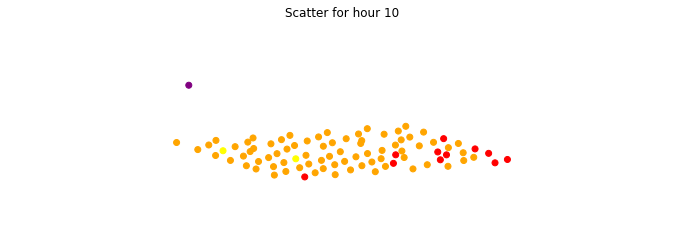

In [51]:
plot_scatter_map(scatter_data, color_data, hour)

In [52]:
scatter_data = get_data_for_scatter_graph(data, hour, date)
color_data = get_color_for_scatter_graph(scatter_data)

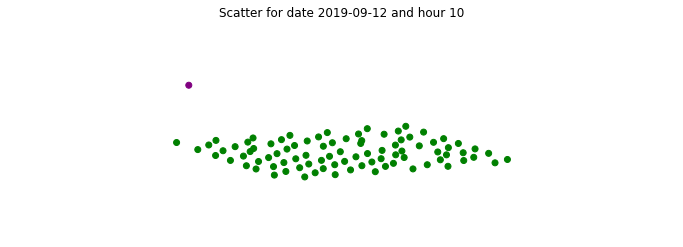

In [53]:
plot_scatter_map(scatter_data, color_data, hour, date)

In [54]:
data[0:60]

,id_cuadra,direccion,tiempo,ocupacion,lugares_cuadra,ocupacion_max,dispon_parq,altas_bajas(dia),fecha_hora,operacion
0,2,General Pinto 545,17:15:31,6,27.0,17,green,184,2019-09-11 17:15:31,NaN
1,2,General Pinto 545,17:20:25,7,27.0,17,green,184,2019-09-11 17:20:25,Entrada
2,2,General Pinto 545,17:34:54,6,27.0,17,green,190,2019-09-11 17:34:54,Salida
3,2,General Pinto 545,17:40:09,5,27.0,17,green,191,2019-09-11 17:40:09,Salida
4,2,General Pinto 545,17:45:05,6,27.0,17,green,192,2019-09-11 17:45:05,Entrada
5,2,General Pinto 545,17:54:43,7,27.0,17,green,197,2019-09-11 17:54:43,Entrada
6,2,General Pinto 545,18:00:29,8,27.0,17,green,200,2019-09-11 18:00:29,Entrada
7,2,General Pinto 545,18:00:29,9,27.0,17,green,200,2019-09-11 18:02:18,Entrada
8,2,General Pinto 545,18:04:18,10,27.0,17,green,203,2019-09-11 18:04:18,Entrada
9,2,General Pinto 545,18:04:18,11,27.0,17,green,203,2019-09-11 18:06:27,Entrada
